In [27]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import zipfile

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS


sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [28]:
## data extraction
zip_path = "Data-20240401.zip"

with zipfile.ZipFile(zip_path, 'r') as zip:
    zip.extractall()

FF5 = pd.read_csv('FF5_2000_2022.csv')
CRSP = pd.read_csv('CRSP_2000_2022.csv')
PS = pd.read_csv('PS_2000_2022.csv')
HXZ5 = pd.read_csv('HXZ5_2000_2022.csv')

In [29]:
CRSP.tail()
# CRSP.loc[CRSP['PERMNO'] == 10324]
# PERMNO: unique identifier for each stock
# MthPrc: monthly price
# MthRet: monthly total return

,PERMNO,YYYYMM,MthPrc,MthRet
82055,93436,202208,275.61,-0.072489
82056,93436,202209,265.25,-0.037589
82057,93436,202210,227.54,-0.142168
82058,93436,202211,194.70,-0.144326
82059,93436,202212,123.18,-0.367334


In [4]:
FF5.tail()
# FF5.describe()
# Mkt-RF: excess return on the market
# SMB: (Small Minus Big) is the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios
# HML: (High Minus Low) is the average return on the two value portfolios minus the average return on the two growth portfolios
# RMW: (Robust Minus Weak) is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,
# CMA: (Conservative Minus Aggressive) is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,

,YYYYMM,Mkt-RF,SMB,HML,RMW,CMA,RF
271,202208,-3.77,1.51,0.31,-4.80,1.30,0.19
272,202209,-9.35,-1.00,0.03,-1.50,-0.85,0.19
273,202210,7.83,1.87,8.05,3.07,6.56,0.23
274,202211,4.60,-2.68,1.39,6.02,3.11,0.29
275,202212,-6.41,-0.13,1.36,0.08,4.18,0.33


In [5]:
HXZ5.tail()
# HXZ5.describe()
# R_ME: the size factor returns
# R_IA: the investment factor returns
# R_ROE: the return on equity factor returns
# R_EG: the expected growth factor returns.

,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,YYYYMM
271,0.1901,-3.7735,1.4291,2.7381,-2.7978,-3.5470,202208
272,0.1929,-9.3458,-1.6943,-0.2182,1.1517,1.7172,202209
273,0.2327,7.8326,4.6904,7.4110,5.3826,-0.9359,202210
274,0.2856,4.6082,-2.3226,2.1779,2.3981,1.2883,202211
275,0.3379,-6.4054,0.2797,3.8672,-0.5108,-0.3618,202212


In [6]:
PS.tail()
# PS.describe()
# AggLiq: Aggregate liquidity level
# eq8: Innovations in aggregated liquidity
# LIQ_V: Traded liquidity factor

,YYYYMM,AggLiq,eq8,LIQ_V
259,202108,0.012418,0.032290,0.003736
260,202109,-0.016866,-0.006602,-0.012899
261,202110,-0.006214,-0.008326,0.015679
262,202111,0.014166,0.030774,-0.026395
263,202112,0.060568,0.070741,-0.023452


In [59]:
# Data preparation
df = (CRSP.merge(FF5,on='YYYYMM')
            .merge(HXZ5, on='YYYYMM')
            .merge(PS, on='YYYYMM',how='left')
            .drop(columns=['R_MKT','R_F','RF','MthPrc'])
)
df['date'] = pd.to_datetime(df['YYYYMM'], format='%Y%m')
exog_vars = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG', 'AggLiq', 'eq8', 'LIQ_V']
df

,PERMNO,YYYYMM,MthRet,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,date
0,10324,200001,0.155556,-4.74,4.44,-1.91,-6.31,4.75,5.6171,2.9355,-4.9998,0.6306,-0.067437,-0.045267,0.010806,2000-01-01
1,10324,200002,0.104567,2.45,18.34,-9.70,-18.73,-0.36,22.1445,-5.3931,-7.5531,-3.1129,-0.041723,-0.013174,0.008217,2000-02-01
2,10324,200003,-0.127312,5.20,-15.35,8.17,11.82,-1.65,-14.4020,1.8350,7.6849,3.5080,-0.006182,0.110161,-0.001077,2000-03-01
3,10324,200004,-0.026185,-6.40,-5.01,7.26,7.66,5.65,-4.8609,3.7873,8.7094,5.1050,-0.225304,-0.217507,-0.043612,2000-04-01
4,10324,200005,0.163892,-4.42,-3.84,4.81,4.17,1.30,-4.5950,0.5085,0.0196,3.7028,0.065954,0.082662,-0.025511,2000-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82055,93436,202208,-0.072489,-3.77,1.51,0.31,-4.80,1.30,1.4291,2.7381,-2.7978,-3.5470,NaN,NaN,NaN,2022-08-01
82056,93436,202209,-0.037589,-9.35,-1.00,0.03,-1.50,-0.85,-1.6943,-0.2182,1.1517,1.7172,NaN,NaN,NaN,2022-09-01
82057,93436,202210,-0.142168,7.83,1.87,8.05,3.07,6.56,4.6904,7.4110,5.3826,-0.9359,NaN,NaN,NaN,2022-10-01
82058,93436,202211,-0.144326,4.60,-2.68,1.39,6.02,3.11,-2.3226,2.1779,2.3981,1.2883,NaN,NaN,NaN,2022-11-01


# 1 (Navie) Factor Regression
rolling-window regression:$$R_{i,t} = \alpha + \sum \beta_{i,j} F_{j,t} + \varepsilon_{i,t}$$

In [79]:
# Data preparation
y = df.loc[df['PERMNO'] == 10324, ['MthRet','date']].set_index(df.loc[df['PERMNO'] == 10324, 'date'])
exog = sm.add_constant(df.loc[df['PERMNO'] == 10324, exog_vars]).set_index(df.loc[df['PERMNO'] == 10324, 'date'])
# Rolling window regression
rres = RollingOLS(y['MthRet'], exog, window=60).fit()

In [80]:
# parameters
params = rres.params.copy()
params

,const,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V
date,,,,,,,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-01,-0.011349,0.002797,-0.032455,0.000369,-0.005419,0.026308,0.028578,-0.009052,-0.001029,-0.000926,-0.240192,-0.146799,0.619666
2011-01-01,-0.011553,0.002698,-0.033181,0.000531,-0.005579,0.027735,0.030307,-0.010801,-0.001199,0.000059,-0.237299,-0.151735,0.638835
2011-02-01,-0.010036,0.002681,-0.032455,0.000113,-0.006227,0.026741,0.029253,-0.008913,-0.001043,-0.000702,-0.238005,-0.154341,0.623801


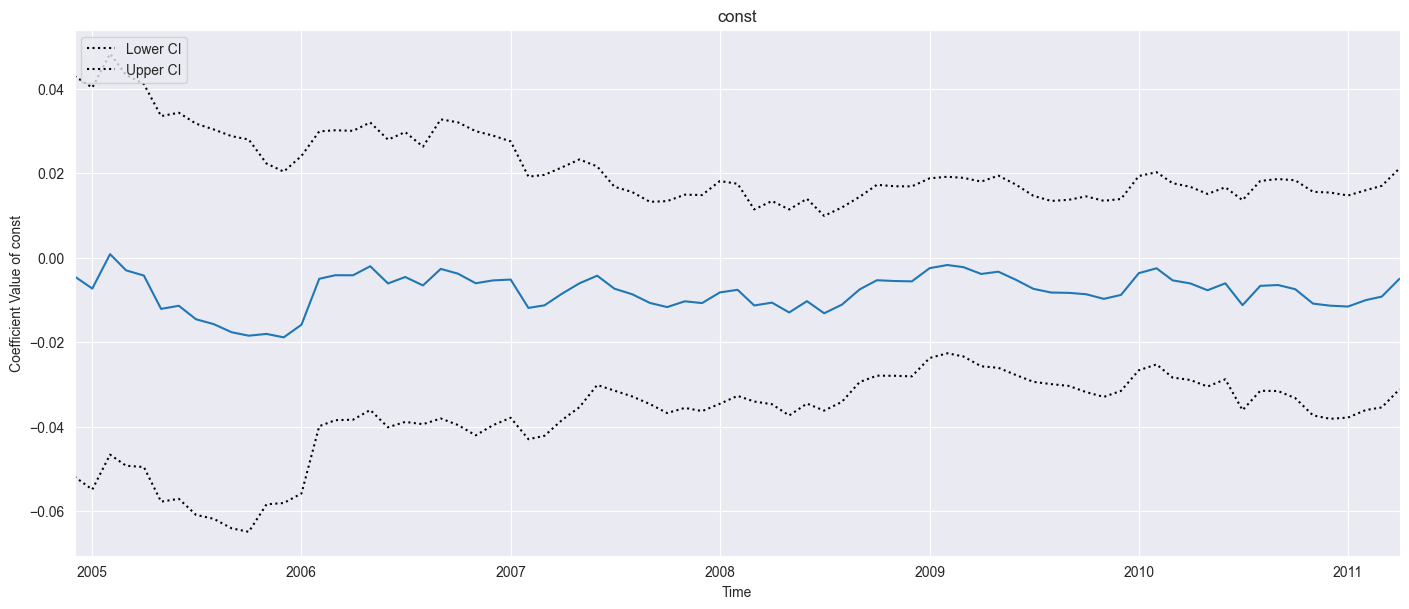

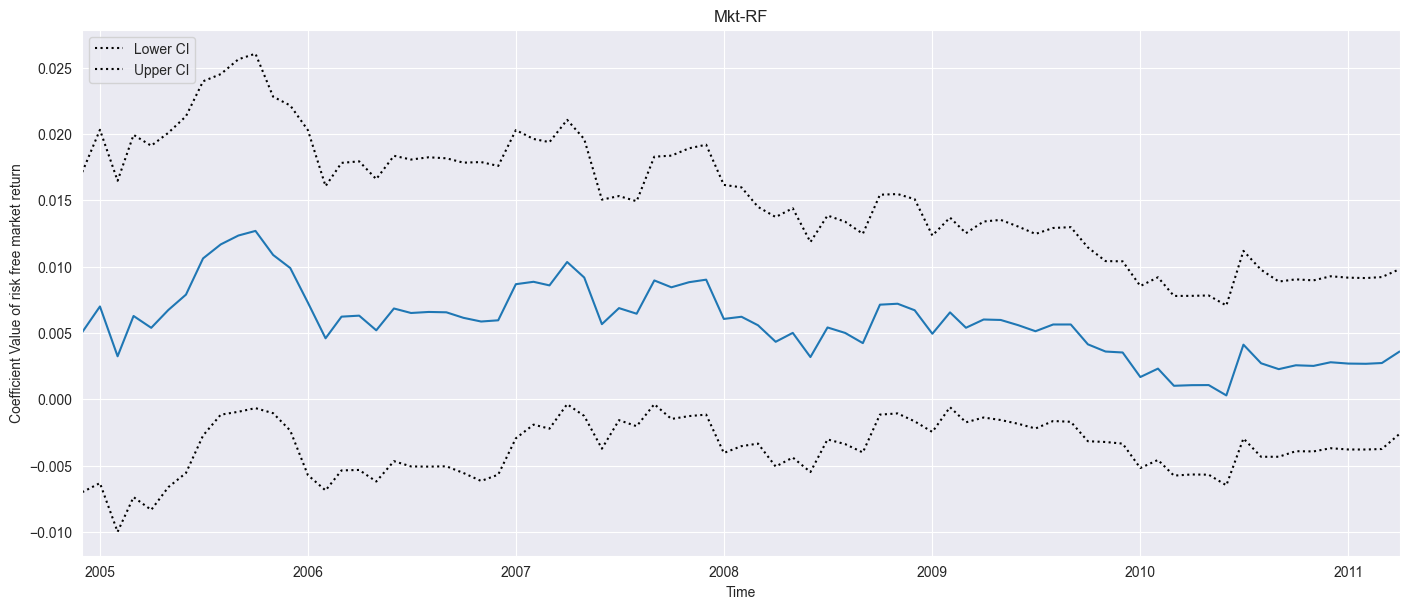

In [81]:
# # time series plot and 95% CI of const and risk free market return
fig = rres.plot_recursive_coefficient(variables=['const'], figsize=(14, 6))
plt.ylabel('Coefficient Value of const')
plt.xlabel('Time')
fig.savefig('const_naive_coeff.png')

fig = rres.plot_recursive_coefficient(variables=['Mkt-RF'], figsize=(14, 6))
plt.ylabel('Coefficient Value of risk free market return')
plt.xlabel('Time')
fig.savefig('mktrf_naive_coeff.png')

# 2 Fama-MacBeth Regression

In [13]:
# data preparation
# extract month
df['month'] = df.index % 100


,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG,AggLiq,eq8,LIQ_V,month
YYYYMM,,,,,,,,,,,,,
200109,-9.25,-5.73,1.45,5.00,3.20,-4.9253,2.8644,9.1920,5.7667,-0.040601,-0.124950,-0.100468,9
200110,2.46,5.28,-7.66,-2.99,-4.54,3.4911,-2.9706,-4.3929,-0.5555,0.069913,0.099017,0.034908,10
200111,7.54,-0.31,2.22,-3.72,-1.62,-1.3907,-1.1391,-8.4893,-2.9927,0.020570,-0.009096,0.032768,11
200112,1.60,5.16,0.85,0.35,-0.27,5.3189,-0.1761,0.5421,-2.2570,0.013297,0.051599,0.068565,12
200201,-1.44,1.26,3.44,4.69,2.83,0.7237,3.2498,0.3033,4.2877,-0.069337,-0.014922,-0.012268,1
200202,-2.29,-0.36,2.16,8.06,5.11,-0.4922,4.4456,5.3235,3.7643,-0.010144,-0.008742,0.037620,2
200203,4.24,4.25,1.06,-1.78,0.57,4.6097,0.7761,-4.7001,-0.5528,0.060897,0.025694,0.078046,3
200204,-5.20,6.72,3.88,4.56,5.38,7.5846,4.0731,5.4639,4.0819,-0.109847,-0.033701,0.051618,4
200205,-1.38,-3.02,1.53,2.37,2.43,-3.1795,2.1865,1.8111,0.6156,-0.033948,-0.044893,0.051118,5


In [ ]:
# cross-sectional reg
beta = (df
        .groupby('YYYYMM')
        .apply(lambda x: smf.ols(
            formula = "CRSP['MthRet'] ~ ",
            data = x
            )
            .fit()
    )
    .reset_index()
)

In [26]:
df.loc[59]

KeyError: 59

In [23]:
from linearmodels import FamaMacBeth as fm
y = CRSP[['PERMNO', 'MthRet']].set_axis(CRSP['YYYYMM'])
res_ts = {}
for ticker, ret in y.groupby('PERMNO'):
    mod_ts = (RollingOLS(ret['MthRet'], sm.add_constant(df.loc[ret.index]), window=60)
              .fit(cov_type='HAC',use_t=True))
    res_ts[ticker] = mod_ts.params

betas = pd.concat({k:pd.DataFrame(v) for k, v in res_ts.items()}, axis=0,names=['PERMNO'])
loadings = betas.drop('const',axis=1)

temp = y.set_index('PERMNO',append=True).swaplevel().groupby('PERMNO').shift(1)
fmdata = (pd.merge(temp.dropna().reset_index(),loadings.reset_index(),on=['YYYYMM','PERMNO'])
          .set_index('PERMNO')
          .set_index('YYYYMM',append=True)
          .dropna()
          .sort_index())

mod_fm = fm(fmdata['MthRet'],sm.add_constant(fmdata[exog_vars]))
res_fm = mod_fm.fit(cov_type='kernel',debiased=False)
print(res_fm.summary)

IndexError: index 59 is out of bounds for axis 0 with size 4

In [ ]:
# time-series aggregation


In [ ]:
# visualization

# 3 LASSO Regression

# 4 Mean-Variance Portfolio